In [1]:
import numpy as np
import os

import random
import torch
import copy

from collections import deque
from IPython.display import clear_output
from matplotlib import pylab as plt

os.chdir(r"C:\Users\HP\Downloads\grid-world")
from grid_world import Gridworld

C:\Users\HP\anaconda3\envs\Reacon\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\HP\anaconda3\envs\Reacon\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\HP\anaconda3\envs\Reacon\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\HP\anaconda3\envs\Reacon\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from grid_world import Gridworld
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.make_move('d')
game.make_move('d')
game.make_move('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
input_dim = 64
output_dim = 4


model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,output_dim)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

gamma = 0.9
epsilon = 0.3
epochs = 50
mem_size = 1000
batch_size = 200
max_moves = 50
h = 0
sync_freq = 500
j=0

In [7]:
replay = deque(maxlen=mem_size)
losses = []
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.make_move(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

49 0.44594818353652954


Text(0, 0.5, 'Loss')

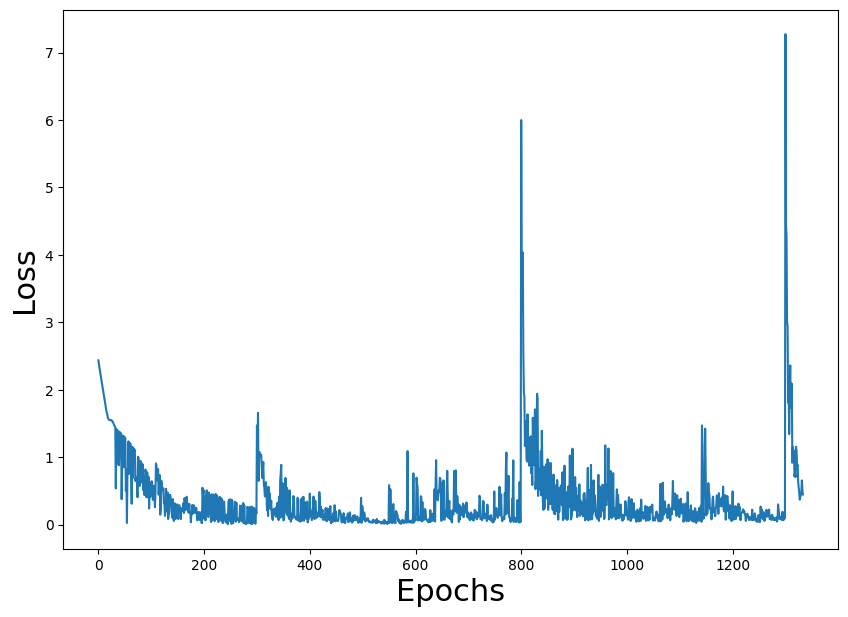

In [8]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [9]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.make_move(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [10]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 157
Win percentage: 15.7%
